# 4个周期划分

注：这里导入的数据中gdp_adjusted列是已经去除了季节性的数据了，在R那边去除了

In [90]:
import pandas as pd

df_gdp = pd.read_excel('output gap.xlsx')
df = df_gdp

df_cpi = pd.read_excel('cpi.xlsx')
df_gdp

,time,actual gdp,gdp_adjusted
0,1992-03-31,5262.8,6091.575306
1,1992-06-30,6484.3,6518.196919
2,1992-09-30,7192.6,6950.272741
3,1992-12-31,8254.8,7393.876668
4,1993-03-31,6834.6,7892.661654
...,...,...,...
126,2023-09-30,319976.3,316449.539078
127,2023-12-31,347890.1,319971.760584
128,2024-03-31,296299.5,323166.557838
129,2024-06-30,320536.5,326264.932571


计算产出缺口output gap

In [91]:
from statsmodels.tsa.filters.hp_filter import hpfilter
# Step 1: 计算产出缺口 (Output Gap)
# 假设 df_gdp 已加载，包含 'time' 和 'actual gdp' 列
df_gdp.set_index('time', inplace=True)

# 使用 HP 滤波器来估算潜在产出
cycle, trend = hpfilter(df_gdp['gdp_adjusted'], lamb=1600)  # lambda = 1600 用于季度数据

# 将潜在产出和产出缺口添加到 DataFrame 中
df_gdp['potential_gdp'] = trend
df_gdp['output_gap'] = ((df_gdp['gdp_adjusted'] - df_gdp['potential_gdp']) / df_gdp['potential_gdp']) * 100


df_gdp.to_excel('df_gdp.xlsx')
df_gdp

,actual gdp,gdp_adjusted,potential_gdp,output_gap
time,,,,
1992-03-31,5262.8,6091.575306,5788.406807,5.237512
1992-06-30,6484.3,6518.196919,6459.766503,0.904528
1992-09-30,7192.6,6950.272741,7131.315679,-2.538703
1992-12-31,8254.8,7393.876668,7803.280334,-5.246558
1993-03-31,6834.6,7892.661654,8475.773317,-6.879746
...,...,...,...,...
2023-09-30,319976.3,316449.539078,317531.973943,-0.340890
2023-12-31,347890.1,319971.760584,321690.588795,-0.534311
2024-03-31,296299.5,323166.557838,325834.453757,-0.818789


In [92]:
df_cpi

,time,cpi
0,1987-01-31,5.1
1,1987-02-28,5.4
2,1987-03-31,5.8
3,1987-04-30,6.7
4,1987-05-31,7.6
...,...,...
449,2024-06-30,0.2
450,2024-07-31,0.5
451,2024-08-31,0.6
452,2024-09-30,0.4


In [93]:
# 过滤数据，仅保留1998年之后的数据
df_gdp = df_gdp[df_gdp.index.year >= 1998]
df_cpi = df_cpi[df_cpi['time'].dt.year >= 1998]

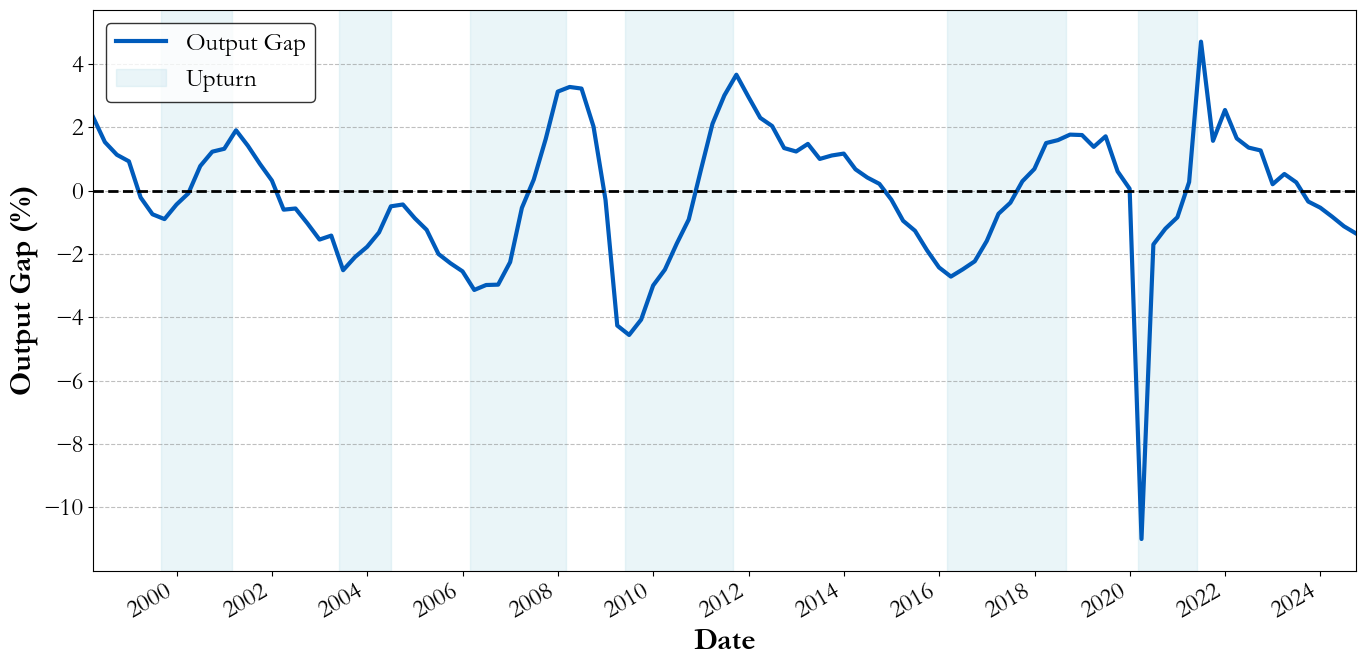

In [94]:


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib import rcParams

# 设置全局字体，确保所有字体放大
rcParams['font.family'] = 'Garamond'
rcParams['font.size'] = 18  # 适当放大字体，提高可读性

# 重要节点
important_dates = [
    '1996-12', '1999-09', '2001-03', '2003-06', '2004-07',
    '2006-03', '2008-03', '2009-06', '2011-09', '2016-03',
    '2018-09', '2020-03', '2021-06'
]
important_dates = pd.to_datetime(important_dates, format='%Y-%m')

# 设定上行周期
upturn_periods = [
    ('1999-09', '2001-03'),
    ('2003-06', '2004-07'),
    ('2006-03', '2008-03'),
    ('2009-06', '2011-09'),
    ('2016-03', '2018-09'),
    ('2020-03', '2021-06')
]

# 确保 df_gdp 的索引精确到月
df_gdp.index = pd.to_datetime(df_gdp.index).normalize()

# 创建图形
fig, ax = plt.subplots(figsize=(14, 7))  # 略微增加图表尺寸

# 绘制 Output Gap 线条（改进颜色）
ax.plot(df_gdp.index, df_gdp['output_gap'], label='Output Gap', color='#005BBB', linewidth=3)  # 使用更柔和的蓝色

# 标记上行周期（仅在图例中标注一次 "Upturn"）
for i, (start, end) in enumerate(upturn_periods):
    start_date = pd.to_datetime(start, format='%Y-%m')
    end_date = pd.to_datetime(end, format='%Y-%m')
    
    ax.axvspan(start_date, end_date, color='#ADD8E6', alpha=0.25, label='Upturn' if i == 0 else "")  # 仅首次添加标签

# 标记重要节点并添加垂直标线
for date in important_dates:
    if date in df_gdp.index:
        ax.scatter(date, df_gdp.loc[date, 'output_gap'], color='#8A2BE2', edgecolors='black', linewidth=1.2, zorder=5, s=100)
        ax.axvline(date, color='gray', linestyle='dotted', alpha=0.7, linewidth=1.2)  # 添加垂直标线
        formatted_date = date.strftime('%Y-%m')
        ax.annotate(formatted_date, (date, df_gdp.loc[date, 'output_gap']),
                    textcoords="offset points", xytext=(0, 20), ha='center', color='black', 
                    fontsize=16, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

# 设置坐标轴标签并加大字体
ax.set_xlabel('Date', fontsize=22, fontweight='bold')
ax.set_ylabel('Output Gap (%)', fontsize=22, fontweight='bold')

# 调整 y 轴范围（使曲线不过于贴边）
ax.set_ylim(df_gdp['output_gap'].min() - 1, df_gdp['output_gap'].max() + 1)

# 限制 x 轴范围，防止显示 2026
ax.set_xlim(df_gdp.index.min(), df_gdp.index.max())

# 添加水平网格线（增强层次感）
ax.grid(axis='y', linestyle='dashed', color='gray', alpha=0.5)

# 在 y=0 处绘制黑色虚线
ax.axhline(0, color='black', linestyle='dashed', linewidth=2)

# 设置 x 轴日期格式
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# 自动调整 x 轴日期
fig.autofmt_xdate()

# 增大图例字体，并放到右上角
ax.legend(loc='upper left', fontsize=18, frameon=True, edgecolor='black')

# 调整布局并导出高清矢量 PDF
plt.tight_layout()
plt.savefig("Output_Gap.pdf", format='pdf', dpi=1200)  # 完全高清矢量输出
plt.show()




C:\Users\20201\AppData\Local\Temp\ipykernel_17472\2309631167.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cpi['time'] = pd.to_datetime(df_cpi['time'], format='%Y-%m')


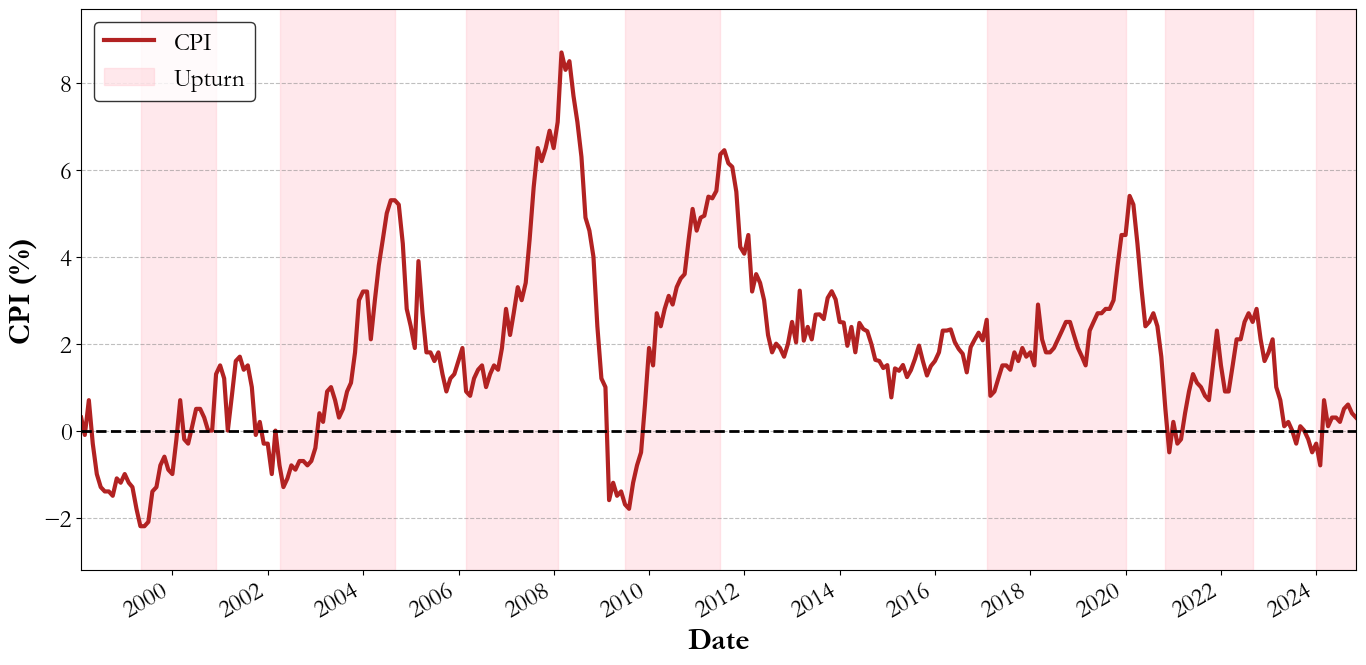

In [95]:


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib import rcParams

# 设置全局字体，确保所有字体放大
rcParams['font.family'] = 'Garamond'
rcParams['font.size'] = 18  # 适当放大字体，提高可读性

# 重要CPI节点
cpi_important_dates = [
    '1999-05', '2000-12', '2002-04', '2004-09', '2006-03', '2008-02',
    '2009-07', '2011-07', '2017-02', '2020-01', '2020-11', '2022-09', '2024-01'
]
cpi_important_dates = pd.to_datetime(cpi_important_dates, format='%Y-%m')

# 设定上行周期
upturn_periods = [
    ('1999-05', '2000-12'),
    ('2002-04', '2004-09'),
    ('2006-03', '2008-02'),
    ('2009-07', '2011-07'),
    ('2017-02', '2020-01'),
    ('2020-11', '2022-09'),
    ('2024-01', '2024-11')  # 将来年份只是示例
]
upturn_periods = [(pd.to_datetime(start, format='%Y-%m'), pd.to_datetime(end, format='%Y-%m')) for start, end in upturn_periods]

# 确保 df_cpi 的时间列为 datetime 类型
df_cpi['time'] = pd.to_datetime(df_cpi['time'], format='%Y-%m')

# 创建图形
fig, ax = plt.subplots(figsize=(14, 7))  # 略微增加尺寸

# 绘制 CPI 线条（使用红色系）
ax.plot(df_cpi['time'], df_cpi['cpi'], label='CPI', color='#B22222', linewidth=3)  # 深红色

# 标记上行周期（仅在图例中标注一次 "Upturn"）
for i, (start, end) in enumerate(upturn_periods):
    ax.axvspan(start, end, color='#FFB6C1', alpha=0.3, label='Upturn' if i == 0 else "")  # 浅红色填充

# 标记重要节点并添加垂直标线
for date in cpi_important_dates:
    if date in df_cpi['time'].values:
        ax.scatter(date, df_cpi[df_cpi['time'] == date]['cpi'].values[0], color='#8B0000', edgecolors='black', linewidth=1.2, zorder=5, s=100)
        ax.axvline(date, color='gray', linestyle='dotted', alpha=0.7, linewidth=1.2)  # 添加垂直标线
        formatted_date = date.strftime('%Y-%m')
        ax.annotate(formatted_date, (date, df_cpi[df_cpi['time'] == date]['cpi'].values[0]),
                    textcoords="offset points", xytext=(0, 20), ha='center', color='black', 
                    fontsize=16, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

# 设置坐标轴标签
ax.set_xlabel('Date', fontsize=22, fontweight='bold')
ax.set_ylabel('CPI (%)', fontsize=22, fontweight='bold')

# 调整 y 轴范围（防止曲线贴边）
ax.set_ylim(df_cpi['cpi'].min() - 1, df_cpi['cpi'].max() + 1)

# 限制 x 轴范围，避免显示 2026
ax.set_xlim(df_cpi['time'].min(), df_cpi['time'].max())

# 添加水平网格线（提升层次感）
ax.grid(axis='y', linestyle='dashed', color='gray', alpha=0.5)

# 在 y=0 处绘制黑色虚线
ax.axhline(0, color='black', linestyle='dashed', linewidth=2)

# 设置 x 轴日期格式
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# 自动调整 x 轴日期
fig.autofmt_xdate()

# 增大图例字体，并放到右上角
ax.legend(loc='upper left', fontsize=18, frameon=True, edgecolor='black')

# 调整布局并导出高清矢量 PDF
plt.tight_layout()
plt.savefig("CPI.pdf", format='pdf', dpi=1200)  # 完全高清矢量输出
plt.show()


4 phase

C:\Users\20201\AppData\Local\Temp\ipykernel_17472\4046278425.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cpi['time'] = pd.to_datetime(df_cpi['time'])


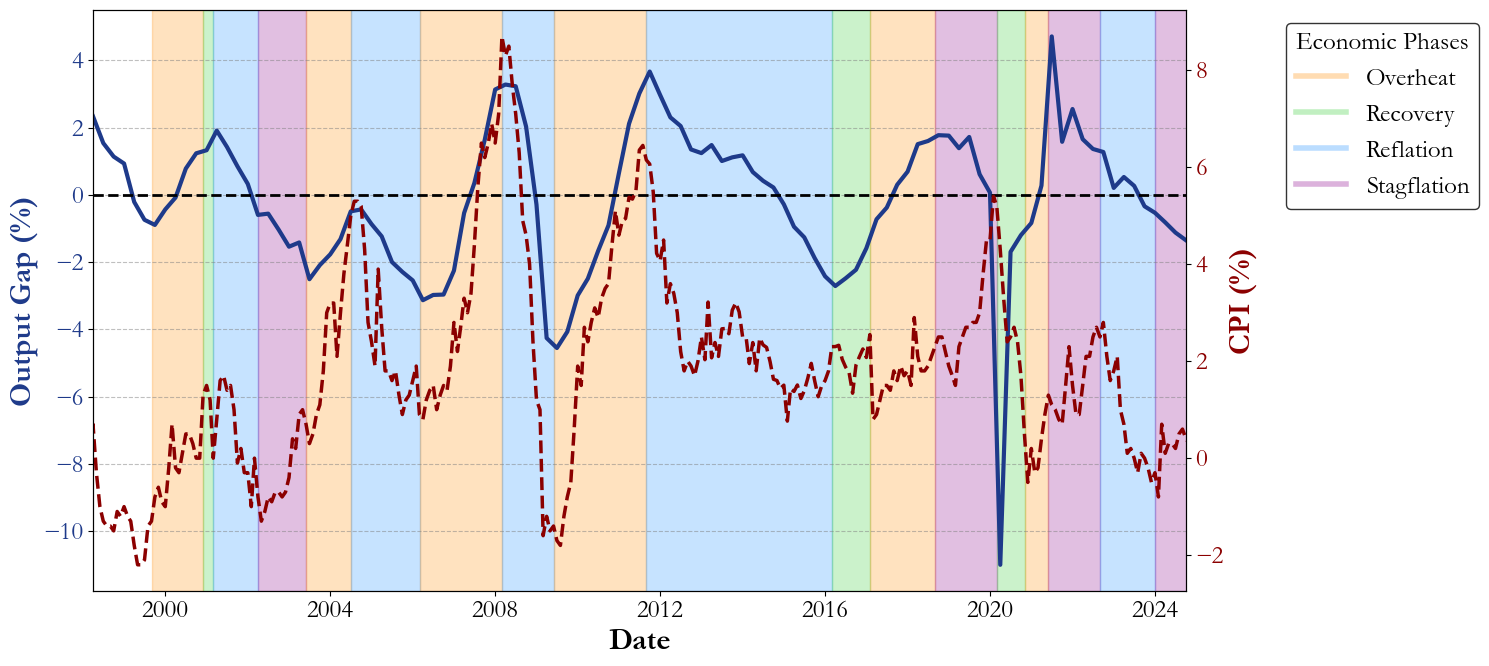

            actual gdp  potential_gdp  output_gap
time                                             
1998-03-31     18049.1   20238.139948    2.333021
1998-06-30     20296.6   20690.099428    1.537059
1998-09-30     21775.6   21139.594514    1.136143
1998-12-31     25074.2   21590.295890    0.929779
1999-03-31     19361.9   22046.024355   -0.212489
...                ...            ...         ...
2023-09-30    319976.3  317531.973943   -0.340890
2023-12-31    347890.1  321690.588795   -0.534311
2024-03-31    296299.5  325834.453757   -0.818789
2024-06-30    320536.5  329970.369049   -1.122960
2024-09-30    332909.8  334103.467455   -1.348989

[107 rows x 3 columns]


In [96]:



import pandas as pd
import matplotlib.pyplot as plt

# 设置全局字体，确保所有字体放大
rcParams['font.family'] = 'Garamond'
rcParams['font.size'] = 18  # 适当放大字体，提高可读性

# 经济周期划分
economic_phases = [
    ('1999-09', '2000-12', 'Overheat'),
    ('2000-12', '2001-03', 'Recovery'),
    ('2001-03', '2002-04', 'Reflation'),
    ('2002-04', '2003-06', 'Stagflation'),
    ('2003-06', '2004-07', 'Overheat'),
    ('2004-07', '2006-03', 'Reflation'),
    ('2006-03', '2008-03', 'Overheat'),
    ('2008-03', '2009-06', 'Reflation'),
    ('2009-06', '2011-09', 'Overheat'),
    ('2011-09', '2016-03', 'Reflation'),
    ('2016-03', '2017-02', 'Recovery'),
    ('2017-02', '2018-09', 'Overheat'),
    ('2018-09', '2020-03', 'Stagflation'),
    ('2020-03', '2020-11', 'Recovery'),
    ('2020-11', '2021-06', 'Overheat'),
    ('2021-06', '2022-09', 'Stagflation'),
    ('2022-09', '2024-01', 'Reflation'),
    ('2024-01', '2024-11', 'Stagflation')
]
economic_phases = [(pd.to_datetime(start), pd.to_datetime(end), phase) for start, end, phase in economic_phases]

# 经济周期颜色
phase_colors = {
    'Overheat': '#FF8C00',    # 深橙色
    'Recovery': '#32CD32',    # 亮绿色
    'Reflation': '#1E90FF',   # 深天蓝色
    'Stagflation': '#8B008B'  # 暗紫色
}

# 确保 df_cpi 和 df_gdp 时间列已转换为 datetime 格式
df_cpi['time'] = pd.to_datetime(df_cpi['time'])
df_cpi.set_index('time', inplace=True)
df_gdp.index = pd.to_datetime(df_gdp.index)

# **调整图像尺寸，使其更宽**
fig, ax1 = plt.subplots(figsize=(20, 7))  # **改为 (16,7) 让内容更宽敞**

# 绘制 Output Gap 线条（主坐标轴，蓝色系）
ax1.plot(df_gdp.index, df_gdp['output_gap'], color='#1E3A8A', linewidth=3, label='Output Gap (%)')

# 绘制经济周期背景阴影
for i, (start, end, phase) in enumerate(economic_phases):
    ax1.axvspan(start, end, color=phase_colors[phase], alpha=0.25, label=phase if i == 0 else "")

# 创建第二个 y 轴共享 x 轴
ax2 = ax1.twinx()

# 绘制 CPI 线条（红色系，虚线）
ax2.plot(df_cpi.index, df_cpi['cpi'], color='#8B0000', linestyle='--', linewidth=2.5, label='Monthly CPI')

# 设置 x 轴标签
ax1.set_xlabel('Date', fontsize=22, fontweight='bold')

# 设置 y 轴标签
ax1.set_ylabel('Output Gap (%)', color='#1E3A8A', fontsize=22, fontweight='bold')
ax2.set_ylabel('CPI (%)', color='#8B0000', fontsize=22, fontweight='bold')

# 调整 y 轴颜色匹配线条
ax1.tick_params(axis='y', labelcolor='#1E3A8A')
ax2.tick_params(axis='y', labelcolor='#8B0000')

# 添加水平网格线
ax1.grid(axis='y', linestyle='dashed', color='gray', alpha=0.5)

# 在 y=0 处绘制黑色虚线
ax1.axhline(0, color='black', linestyle='dashed', linewidth=2)

# 限制 x 轴范围
ax1.set_xlim(df_gdp.index.min(), df_gdp.index.max())

# 生成经济周期颜色图例（**移动到图外右侧，间距更大**）
handles = [
    plt.Line2D([0], [0], color='#FF8C00', lw=4, alpha=0.3, label='Overheat'),
    plt.Line2D([0], [0], color='#32CD32', lw=4, alpha=0.3, label='Recovery'),
    plt.Line2D([0], [0], color='#1E90FF', lw=4, alpha=0.3, label='Reflation'),
    plt.Line2D([0], [0], color='#8B008B', lw=4, alpha=0.3, label='Stagflation')
]
legend = ax1.legend(handles=handles, title="Economic Phases", fontsize=18, frameon=True, edgecolor='black', 
                     loc='upper left', bbox_to_anchor=(1.08, 1))  # **图例右移，避免过于贴近图像**

# **调整布局，让图例不会挤压图像**
plt.tight_layout(rect=[0, 0, 0.78, 1])  # **主图占 78% 宽度，使得右侧图例有足够空间**

# 导出高清矢量 PDF
plt.savefig("Investment_Clock.pdf", format='pdf', dpi=1200, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

# 显示最终的 GDP 产出缺口结果
print(df_gdp[['actual gdp', 'potential_gdp', 'output_gap']])
